## Convolutional Neural Networks and Computer Vision with TensorFlow

In [1]:
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

### 1. Data preparation & preprocessing

In [2]:
train_path = pathlib.Path("image_data/pizza_steak/train/")
class_names = np.array(sorted([item.name for item in train_path.glob('*')]))

print('Type of classes: ', class_names)

Type of classes:  ['pizza' 'steak']


In [3]:
def view_random_image(target_path, target_class):
    target_folder = target_path + target_class

    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    print(f"Image shape: {img.shape}")

    return img

In [4]:
def plot_loss_curves(history):
    print(history)
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label  ='training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [5]:
def load_and_prep_image(filename, img_shape = 224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.resize(img, size = [img_shape, img_shape])
    img = img/ 255.
    
    return img

In [6]:
def pred_and_plot(model, filename, class_names):
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

Image shape: (512, 512, 3)


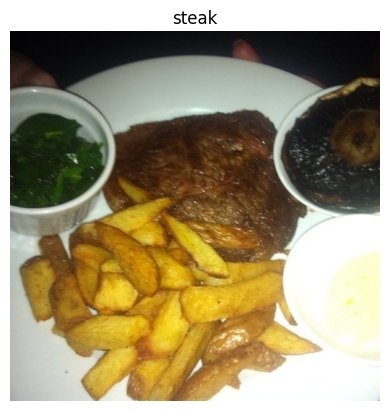

In [7]:
img = view_random_image(target_path = "image_data/pizza_steak/train/", target_class = "steak")

In [8]:
num_steak_images_train = len(os.listdir("image_data/pizza_steak/train/steak"))

print('number of train for steak`s image: ', num_steak_images_train)

number of train for steak`s image:  750


Image shape: (340, 512, 3)
Image shape: (512, 512, 3)


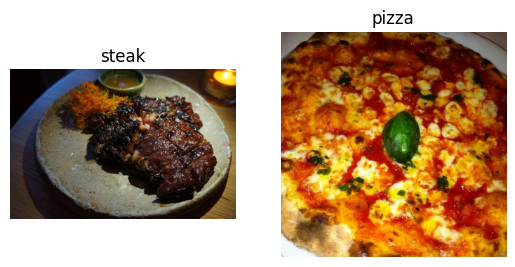

In [9]:
plt.figure()

plt.subplot(1, 2, 1)
steak_img = view_random_image("image_data/pizza_steak/train/", "steak")

plt.subplot(1, 2, 2)
pizza_img = view_random_image("image_data/pizza_steak/train/", "pizza")

In [10]:
train_path = "image_data/pizza_steak/train/"
test_path = "image_data/pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale = 1./ 255)
valid_datagen = ImageDataGenerator(rescale = 1./ 255)

train_data = train_datagen.flow_from_directory(train_path, batch_size = 32, target_size = (224, 224), 
    class_mode = "binary", seed = 42)
valid_data = train_datagen.flow_from_directory(test_path, batch_size = 32, target_size = (224, 224), 
    class_mode = "binary", seed = 42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


### 2. Dive into computer vision

Feature extraction - convolution (filter), ReLU (detect), and maximum pooling (condense) <br>
1. Convolution - Filter an image for a particular feature
2. ReLU - Detect that feature within the filtered image
3. Maximum pooling - Condense the image to enhance the features

In [ ]:
random_image = random.sample(os.listdir("image_data/pizza_steak/train/steak"), 1)
image_path = "image_data/pizza_steak/train/steak/" + random_image[0]

image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize = (6, 6))
plt.imshow(tf.squeeze(image))
plt.axis('off')
plt.show();

In [12]:
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

image = tf.image.convert_image_dtype(image, dtype = tf.float32)
image = tf.expand_dims(image, axis = 0)

kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype = tf.float32)

https://ezyang.github.io/convolution-visualizer/

### 3. Model Building
First cnn model

In [13]:
tf.random.set_seed(42)

first_model = tf.keras.models.Sequential([
    ### First layer
    ### Kernel size can also be (3, 3)
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = "relu", input_shape = (224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2, padding = "valid"),
    ### Second layer
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.Conv2D(10, 3, activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    ### Flatten layer
    tf.keras.layers.Flatten(),
    ### Output/ Fully connected layer
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

first_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [14]:
first_history = first_model.fit(train_data, epochs = 5, 
    steps_per_epoch = len(train_data), validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 41s 847ms/step - loss: 0.6869 - accuracy: 0.5247 - val_loss: 0.6347 - val_accuracy: 0.7520
Epoch 2/5
47/47 [==============================] - 38s 815ms/step - loss: 0.5486 - accuracy: 0.7447 - val_loss: 0.4520 - val_accuracy: 0.8040
Epoch 3/5
47/47 [==============================] - 37s 796ms/step - loss: 0.4594 - accuracy: 0.7980 - val_loss: 0.3773 - val_accuracy: 0.8640
Epoch 4/5
47/47 [==============================] - 40s 860ms/step - loss: 0.4068 - accuracy: 0.8220 - val_loss: 0.3473 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 43s 905ms/step - loss: 0.3590 - accuracy: 0.8507 - val_loss: 0.3260 - val_accuracy: 0.8720


Second model

In [15]:
tf.random.set_seed(42)

second_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
  tf.keras.layers.Dense(4, activation = 'relu'),
  tf.keras.layers.Dense(4, activation = 'relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

second_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

second_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
second_history = second_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), 
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 156ms/step - loss: 0.7092 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 7s 148ms/step - loss: 0.6932 - accuracy: 0.4893 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 7s 148ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 7s 150ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 7s 156ms/step - loss: 0.6932 - accuracy: 0.4747 - val_loss: 0.6931 - val_accuracy: 0.5000


Third model

In [17]:
tf.random.set_seed(42)

third_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape = (224, 224, 3)),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(100, activation = 'relu'),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

third_model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

third_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15063101 (57.46 MB)
Trainable params: 15063101 (57.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
third_history = third_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), 
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 15s 297ms/step - loss: 2.9124 - accuracy: 0.6220 - val_loss: 2.9053 - val_accuracy: 0.5660
Epoch 2/5
47/47 [==============================] - 13s 276ms/step - loss: 0.7747 - accuracy: 0.7327 - val_loss: 0.6112 - val_accuracy: 0.7180
Epoch 3/5
47/47 [==============================] - 12s 265ms/step - loss: 0.5504 - accuracy: 0.7607 - val_loss: 0.4605 - val_accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 14s 288ms/step - loss: 0.5312 - accuracy: 0.7720 - val_loss: 0.5093 - val_accuracy: 0.7560
Epoch 5/5
47/47 [==============================] - 13s 285ms/step - loss: 0.4295 - accuracy: 0.8207 - val_loss: 0.5759 - val_accuracy: 0.7280


Forth model

In [19]:
forth_model = Sequential([
  Conv2D(filters = 10, 
         kernel_size = 3, 
         strides = 1,
         padding = 'valid',
         activation = 'relu', 
         input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  Flatten(),
  Dense(1, activation='sigmoid')
])

forth_model.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])

forth_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
forth_history = forth_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 52s 1s/step - loss: 0.9028 - accuracy: 0.6387 - val_loss: 0.4832 - val_accuracy: 0.7700
Epoch 2/5
47/47 [==============================] - 53s 1s/step - loss: 0.4738 - accuracy: 0.7940 - val_loss: 0.4621 - val_accuracy: 0.7840
Epoch 3/5
47/47 [==============================] - 54s 1s/step - loss: 0.3744 - accuracy: 0.8367 - val_loss: 0.3940 - val_accuracy: 0.8100
Epoch 4/5
47/47 [==============================] - 52s 1s/step - loss: 0.2440 - accuracy: 0.9153 - val_loss: 0.4241 - val_accuracy: 0.8020
Epoch 5/5
47/47 [==============================] - 52s 1s/step - loss: 0.1174 - accuracy: 0.9680 - val_loss: 0.4279 - val_accuracy: 0.8160


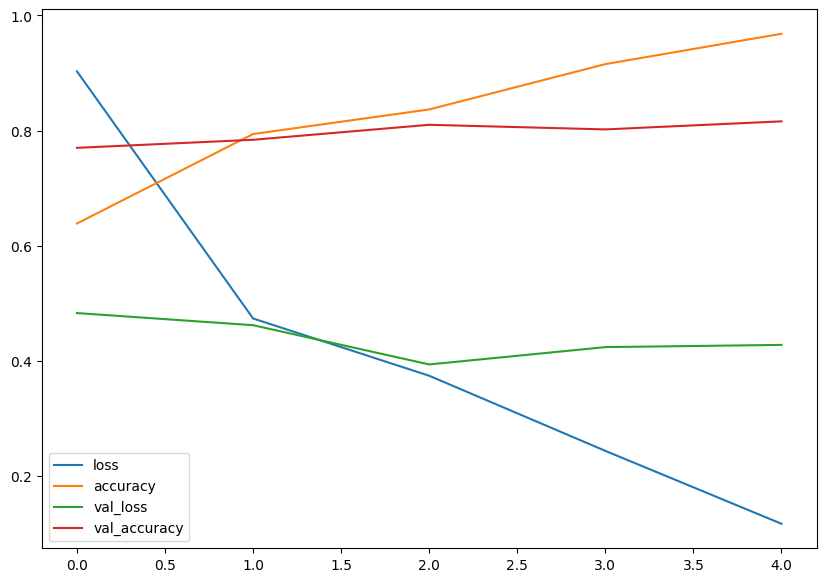

In [21]:
pd.DataFrame(forth_history.history).plot(figsize=(10, 7));

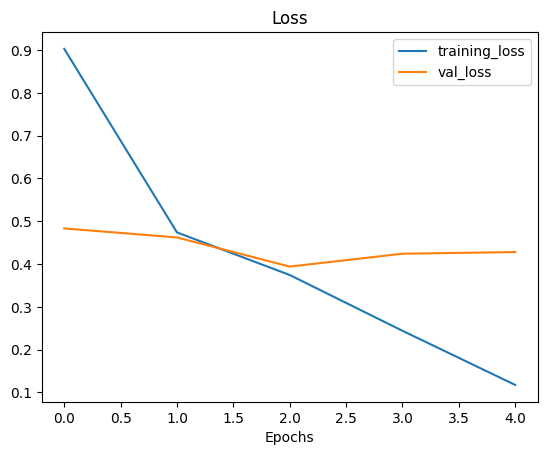

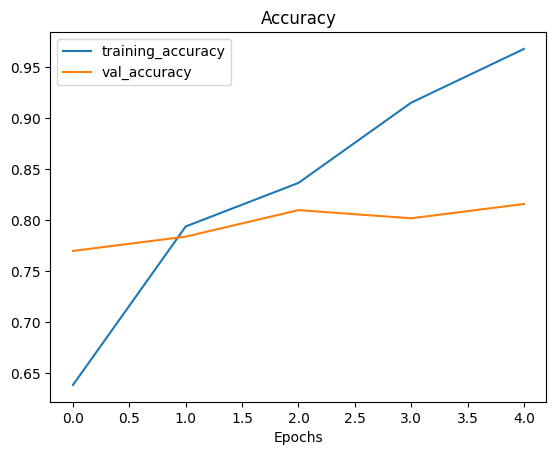

In [22]:
plot_loss_curves(forth_history)

Fifth model

In [23]:
fifth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(pool_size = 2),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

fifth_model.compile(loss = 'binary_crossentropy', optimizer = Adam(),
    metrics = ['accuracy'])

fifth_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

In [24]:
fifth_history = fifth_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
    validation_data = valid_data, validation_steps = len(valid_data))

Epoch 1/5
47/47 [==============================] - 21s 437ms/step - loss: 0.5918 - accuracy: 0.6900 - val_loss: 0.4569 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 21s 447ms/step - loss: 0.4389 - accuracy: 0.8060 - val_loss: 0.3478 - val_accuracy: 0.8540
Epoch 3/5
47/47 [==============================] - 22s 460ms/step - loss: 0.3970 - accuracy: 0.8267 - val_loss: 0.3407 - val_accuracy: 0.8680
Epoch 4/5
47/47 [==============================] - 22s 459ms/step - loss: 0.3703 - accuracy: 0.8353 - val_loss: 0.3363 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 21s 437ms/step - loss: 0.3455 - accuracy: 0.8527 - val_loss: 0.3249 - val_accuracy: 0.8520


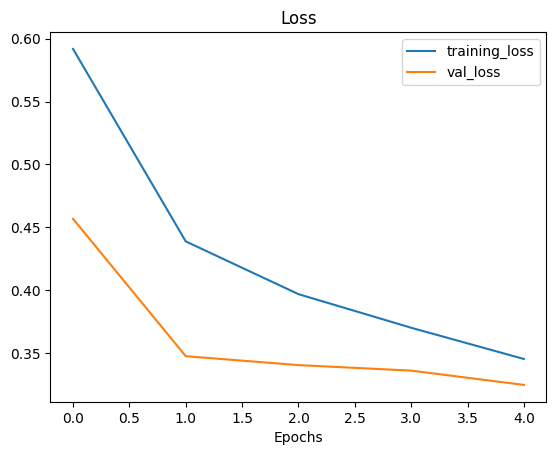

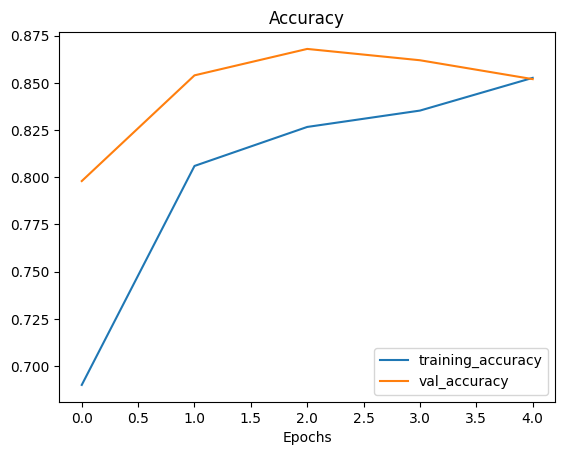

In [25]:
plot_loss_curves(fifth_history)

Data augmentation

In [26]:
train_datagen_augmented = ImageDataGenerator(rescale = 1/ 255.,
    rotation_range = 20,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1/ 255.)
test_datagen = ImageDataGenerator(rescale = 1/ 255.)

In [27]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False)

train_data = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False)

test_data = test_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary')

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


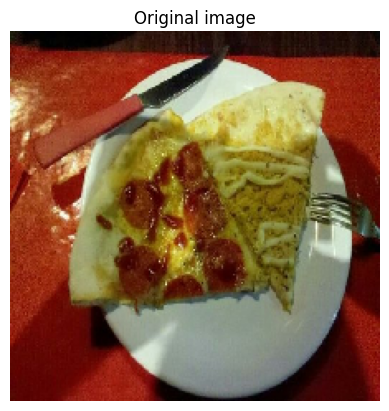

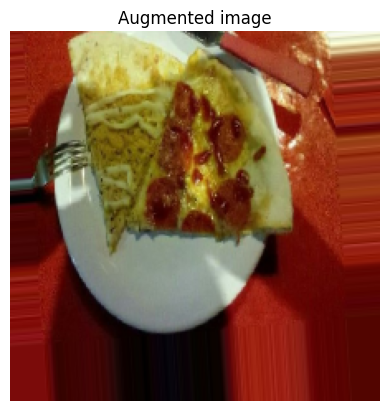

In [28]:
### Original image vs augmented image
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() 

random_number = random.randint(0, 31)
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Sixth model

In [29]:
sixth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(pool_size = 2),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

sixth_model.compile(loss = 'binary_crossentropy', optimizer = Adam(),
    metrics = ['accuracy'])

sixth_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 26, 26, 10)       

In [30]:
sixth_history = sixth_model.fit(train_data_augmented, epochs = 5, steps_per_epoch = len(train_data_augmented),
    validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 35s 740ms/step - loss: 0.7420 - accuracy: 0.5700 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 34s 721ms/step - loss: 0.6970 - accuracy: 0.5000 - val_loss: 0.6893 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 33s 699ms/step - loss: 0.6986 - accuracy: 0.5067 - val_loss: 0.6792 - val_accuracy: 0.5380
Epoch 4/5
47/47 [==============================] - 30s 633ms/step - loss: 0.6911 - accuracy: 0.6033 - val_loss: 0.6776 - val_accuracy: 0.6520
Epoch 5/5
47/47 [==============================] - 27s 577ms/step - loss: 0.6861 - accuracy: 0.5913 - val_loss: 0.6608 - val_accuracy: 0.5940


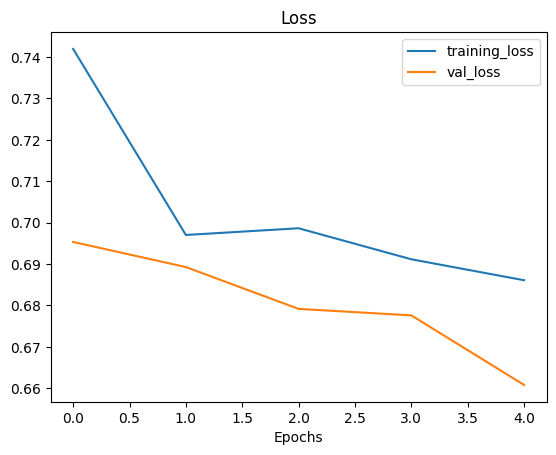

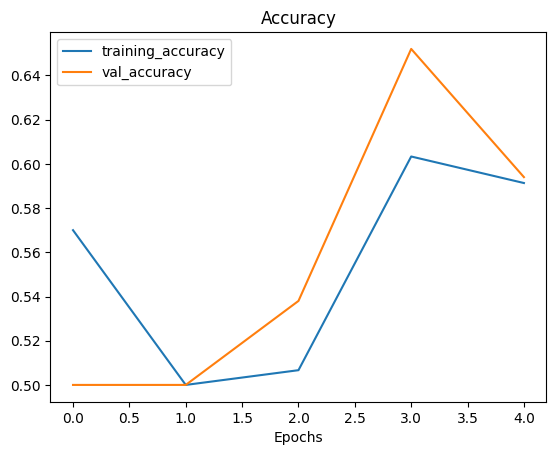

In [31]:
plot_loss_curves(sixth_history)

In [32]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_path, target_size = (224, 224), 
    batch_size = 32, class_mode = 'binary', shuffle = True)

Found 1500 images belonging to 2 classes.


In [33]:
seventh_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

seventh_model.compile(loss = 'binary_crossentropy', optimizer = Adam(),
    metrics = ['accuracy'])

seventh_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 10)       

In [34]:
seventh_history = seventh_model.fit(train_data_augmented_shuffled,
    epochs = 5, steps_per_epoch = len(train_data_augmented_shuffled),
    validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 29s 595ms/step - loss: 0.6278 - accuracy: 0.6340 - val_loss: 0.4746 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 27s 576ms/step - loss: 0.5243 - accuracy: 0.7340 - val_loss: 0.3807 - val_accuracy: 0.8380
Epoch 3/5
47/47 [==============================] - 28s 587ms/step - loss: 0.5011 - accuracy: 0.7553 - val_loss: 0.3923 - val_accuracy: 0.8360
Epoch 4/5
47/47 [==============================] - 28s 583ms/step - loss: 0.4746 - accuracy: 0.7813 - val_loss: 0.3760 - val_accuracy: 0.8400
Epoch 5/5
47/47 [==============================] - 27s 578ms/step - loss: 0.4684 - accuracy: 0.7820 - val_loss: 0.3640 - val_accuracy: 0.8520


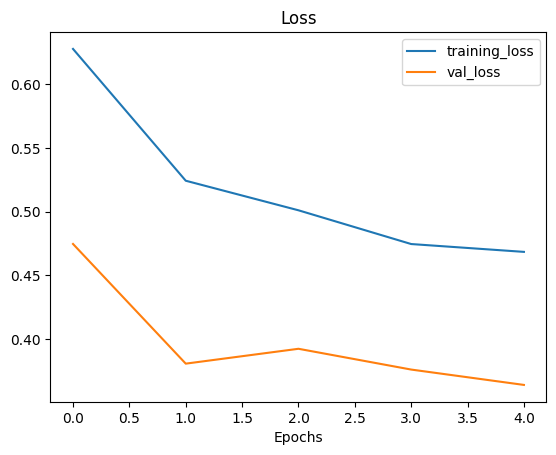

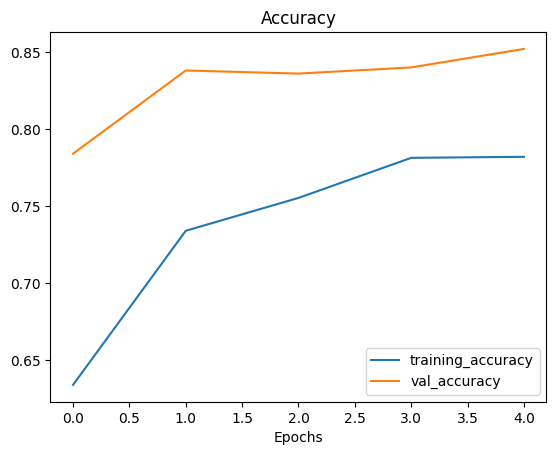

In [35]:
plot_loss_curves(seventh_history)

Eight model

In [36]:
eight_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation = 'sigmoid')
])

eight_model.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

eight_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                                

In [37]:
eight_history = eight_model.fit(train_data_augmented_shuffled,
    epochs = 5, steps_per_epoch = len(train_data_augmented_shuffled),
    validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
47/47 [==============================] - 43s 895ms/step - loss: 0.7081 - accuracy: 0.5360 - val_loss: 0.5904 - val_accuracy: 0.7840
Epoch 2/5
47/47 [==============================] - 44s 940ms/step - loss: 0.6026 - accuracy: 0.6847 - val_loss: 0.4574 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 44s 941ms/step - loss: 0.5621 - accuracy: 0.7167 - val_loss: 0.4554 - val_accuracy: 0.7900
Epoch 4/5
47/47 [==============================] - 42s 881ms/step - loss: 0.5483 - accuracy: 0.7233 - val_loss: 0.4315 - val_accuracy: 0.8260
Epoch 5/5
47/47 [==============================] - 43s 915ms/step - loss: 0.5189 - accuracy: 0.7660 - val_loss: 0.4007 - val_accuracy: 0.8300


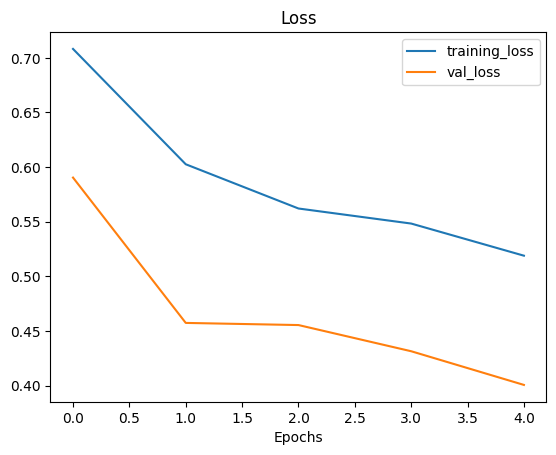

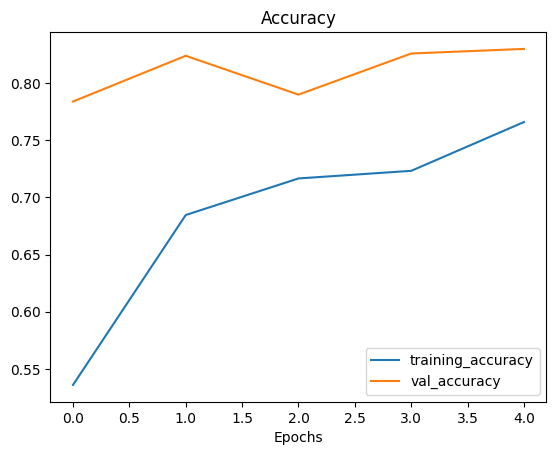

In [38]:
plot_loss_curves(eight_history)

Make prediction

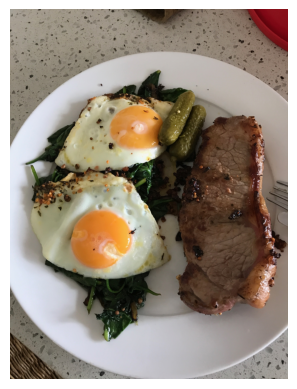

In [41]:
steak = mpimg.imread("image_data/03-steak.jpeg")

plt.imshow(steak)
plt.axis(False);

In [42]:
steak.shape

(4032, 3024, 3)

In [43]:
steak = load_and_prep_image("image_data/03-steak.jpeg")
steak.shape

TensorShape([224, 224, 3])

In [44]:
steak = tf.expand_dims(steak, axis = 0)
steak.shape

TensorShape([1, 224, 224, 3])

In [45]:
pred = sixth_model.predict(steak)
pred

1/1 [==============================] - 0s 126ms/step


array([[0.47510618]], dtype=float32)

In [46]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'pizza'

1/1 [==============================] - 0s 55ms/step


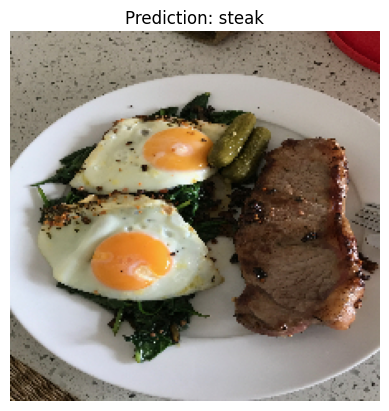

In [48]:
pred_and_plot(eight_model, "image_data/03-steak.jpeg", class_names)

1/1 [==============================] - 0s 32ms/step


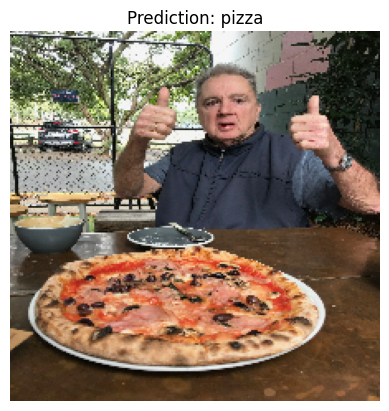

In [51]:
pred_and_plot(eight_model, "image_data/03-pizza-dad.jpeg", class_names)

Multiclass

In [58]:
train_path = "image_data/10_food_classes_all_data/train/"
test_path = "image_data/10_food_classes_all_data/test/"

In [59]:
data_dir = pathlib.Path(train_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


Image shape: (512, 512, 3)


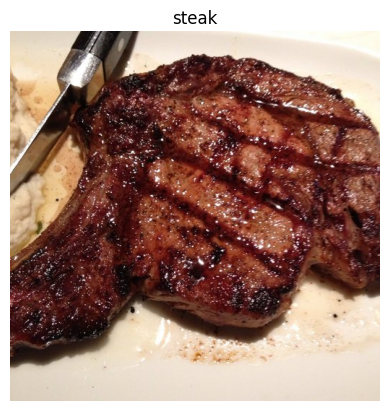

In [60]:
img = view_random_image(target_path = train_path, target_class = random.choice(class_names))

In [61]:
train_datagen = ImageDataGenerator(rescale = 1/ 255.)
test_datagen = ImageDataGenerator(rescale = 1/ 255.)

train_data = train_datagen.flow_from_directory(train_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical')

test_data = train_datagen.flow_from_directory(test_path,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


Ninth model

In [62]:
ninth_model = Sequential([
  Conv2D(10, 3, activation = 'relu', input_shape = (224, 224, 3)),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation = 'relu'),
  Conv2D(10, 3, activation = 'relu'),
  MaxPool2D(),
  Flatten(),
  Dense(10, activation = 'softmax')
])

ninth_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

ninth_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_23 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                                

In [63]:
ninth_history = ninth_model.fit(train_data, epochs = 5, steps_per_epoch = len(train_data),
    validation_data = test_data, validation_steps = len(test_data))

Epoch 1/5
235/235 [==============================] - 204s 866ms/step - loss: 2.1399 - accuracy: 0.2108 - val_loss: 1.9727 - val_accuracy: 0.2964
Epoch 2/5
235/235 [==============================] - 193s 820ms/step - loss: 1.9087 - accuracy: 0.3387 - val_loss: 1.8487 - val_accuracy: 0.3552
Epoch 3/5
235/235 [==============================] - 185s 786ms/step - loss: 1.7222 - accuracy: 0.4144 - val_loss: 1.8538 - val_accuracy: 0.3556
Epoch 4/5
235/235 [==============================] - 190s 807ms/step - loss: 1.3746 - accuracy: 0.5423 - val_loss: 2.0784 - val_accuracy: 0.3152
Epoch 5/5
235/235 [==============================] - 195s 831ms/step - loss: 0.7911 - accuracy: 0.7423 - val_loss: 2.6798 - val_accuracy: 0.2908


In [64]:
ninth_model.evaluate(test_data)

79/79 [==============================] - 20s 253ms/step - loss: 2.6798 - accuracy: 0.2908


[2.6797876358032227, 0.290800005197525]

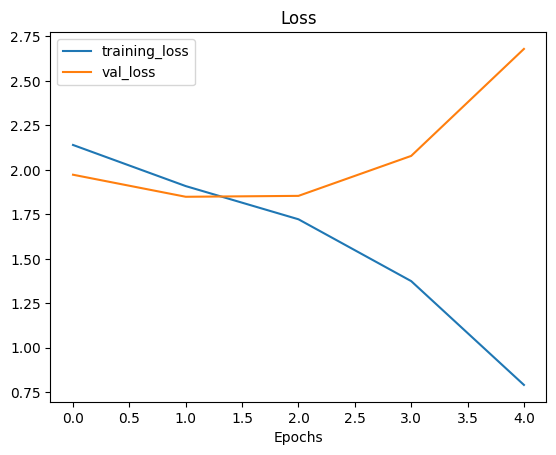

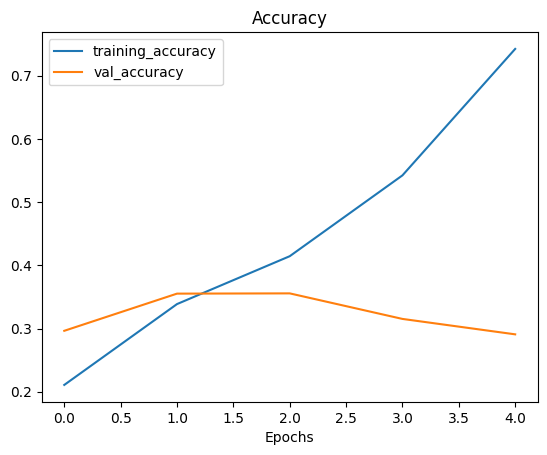

In [65]:
plot_loss_curves(ninth_history)